In [1]:
import sys
import warnings
# filters the nan-median slicing warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
#warnings.filterwarnings('error')
import numpy as np
from copy import deepcopy
from IPython.display import clear_output
import os
from matplotlib import cm
import torch

from modelagnosic_superior_training.inducingPointSampler import *
from modelagnosic_superior_training.globalModel import *
from modelagnosic_superior_training.SABER import *
from modelagnosic_superior_training.AL_base import *
from modelagnosic_superior_training.AL_framework import activeLearner

import matplotlib.pyplot as plt
%matplotlib inline

saveDir = 'results'
dataName = 'doppler'
resultFile = os.path.join(saveDir, dataName + '_resultFile.tar')

inputDim = 1
inputSpaceBounds = np.array([[0.]*inputDim,[1.]*inputDim])

xPlot = equidistantInput(10000, inputSpaceBounds)

testDensity = inputDensityUnif
randTestDistribution = randInputUnif
testDensityPlot = testDensity(xPlot, inputSpaceBounds)

eps = 0.05
a = 1/eps
bb = 1 + 1/eps
def f(x):
    return(a*x + 1)
def labelFun(x):
    return((x*(1-x))**0.5*np.sin(2*np.pi*bb/f(x)))
yPlot = labelFun(xPlot)
labelScaling = 7/np.std(yPlot)
def labelFun(x):
    return(labelScaling*(x*(1-x))**0.5*np.sin(2*np.pi*bb/f(x)))

noiseStdDev = 1
def localNoiseVar(x):
    return(np.ones(len(x))*noiseStdDev**2)
localNoiseVariance = None

if False:
    noiseStdDevHigh = 3
    noiseStdDevLow = 1
    def localNoiseVar(x):
        return(((noiseStdDevHigh-noiseStdDevLow)*(1-2*np.abs(x.ravel() - 0.5*np.ones(len(x)))) + noiseStdDevLow)**2)
    localNoiseVariance = localNoiseVar
    
def noisyLabelFun(x):
    return(labelFun(x) + (localNoiseVar(x)**0.5*np.random.normal(size=len(x))).reshape(-1,1))

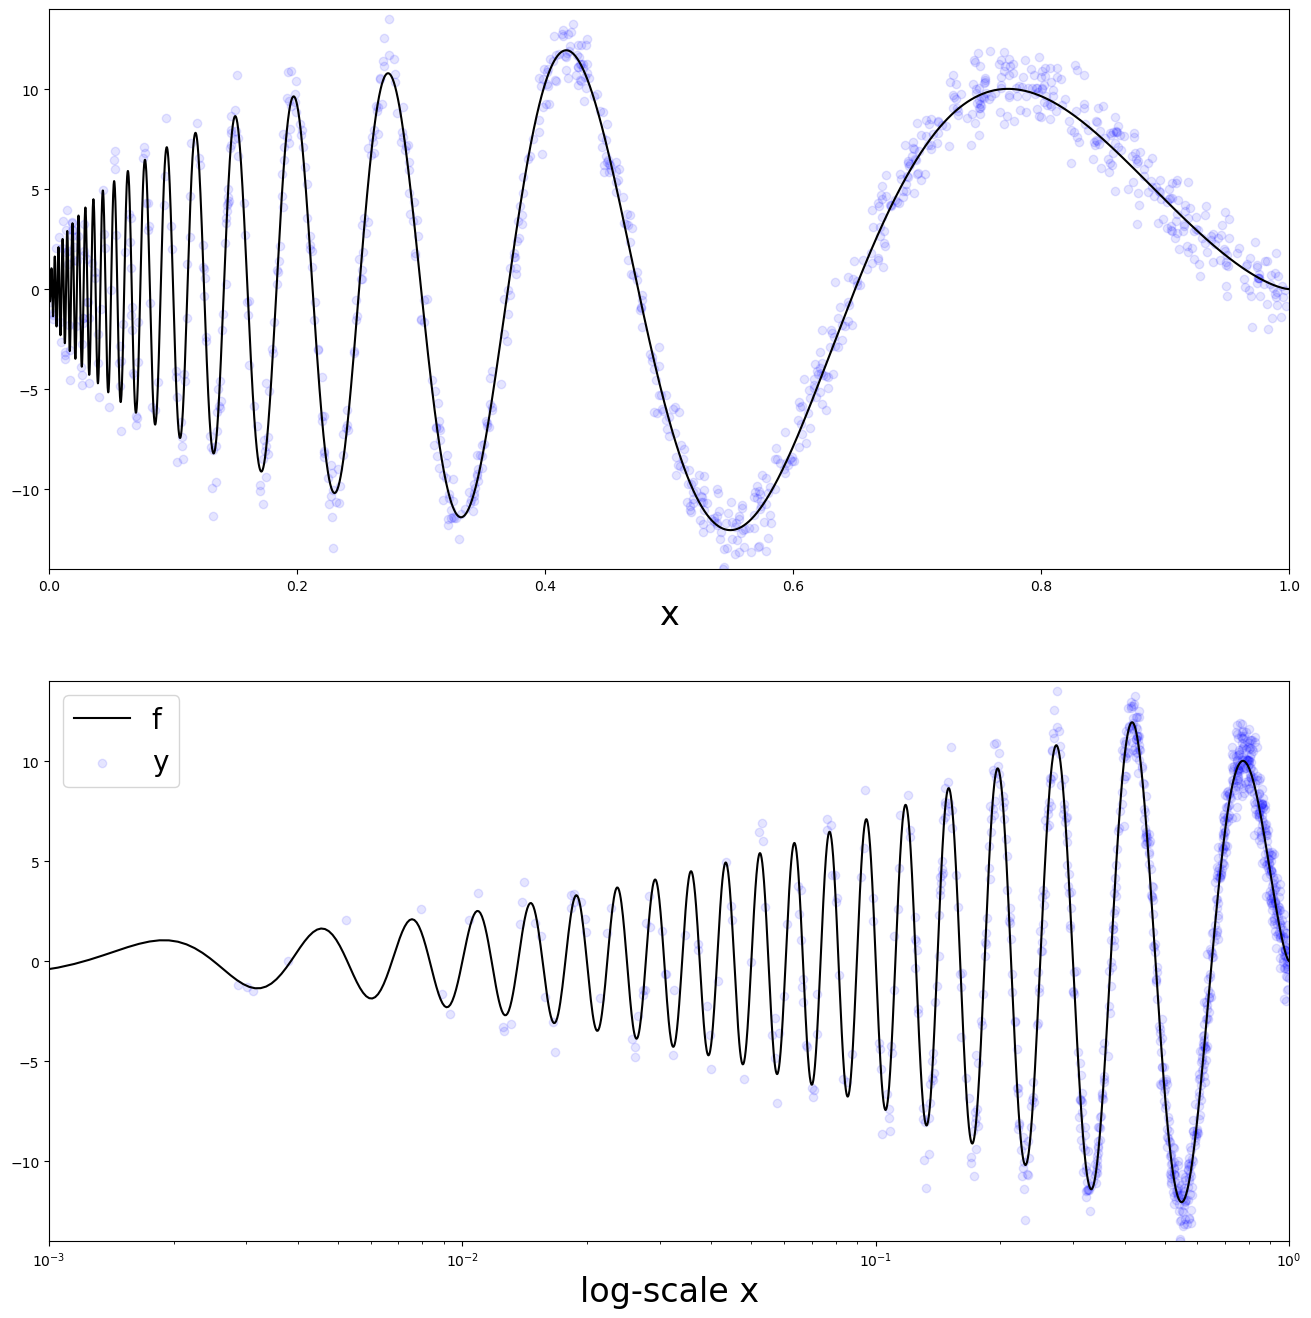

In [2]:
vPlot = localNoiseVar(xPlot)
yPlot = labelFun(xPlot)

n = int(2**10)
seed = 1
np.random.seed(seed)
currentX = randInputUnif(n, inputSpaceBounds)
currentY = noisyLabelFun(currentX)

fig, ax = plt.subplots(2, 1)
fig.set_figheight(16)
fig.set_figwidth(16)
ax[0].set_xlabel('x', fontsize=24)
ax[0].set_xlim(0,1)
ax[0].set_ylim(-14, 14)
ax[0].plot(xPlot, yPlot, 'k-',label='f')
ax[0].scatter(currentX, currentY, color = "blue", alpha=0.1,label='y')
############
ax[1].set_xlabel('log-scale x', fontsize=24)
ax[1].set_xlim(0.001, 1.)
ax[1].set_ylim(-14, 14)
ax[1].semilogx(xPlot, yPlot, 'k-',label='f')
ax[1].scatter(currentX, currentY, color = "blue", alpha=0.1,label='y')
############

##########
ax[1].legend(loc='upper left', fontsize = 20)
plt.draw()
plt.pause(2)
plt.close(fig)

In [3]:
################ reasonable parameter groups #################

# experimental parameters
def initExpPars():
    expPars = {}
    expPars['validationSize'] = None
    expPars['valLoss'] = 'mll'
    expPars['trainingSizes'] = []
    expPars['iters'] = 0
    expPars['repetitions'] = 1
    expPars['splitRatio'] = 1
    expPars['labelModel'] = True
    expPars['derivativeModel'] = False
    return expPars
expPars = initExpPars()
expPars['validationSize'] = int(2**10)
expPars['trainingSizes'] = []
for i in range(9,16):
    expPars['trainingSizes'].append(int(2**i))
expPars['iters'] = len(expPars['trainingSizes'])

# AL-related parameters
def initALPars():
    alPars = {}
    alPars['initialSamplingStrategy'] = 'random'
    alPars['Q'] = np.Inf
    alPars['inputDim'] = None
    alPars['inputSpaceBounds'] = None
    alPars['intrinsicDim'] = None
    alPars['updateTrainingDensity'] = True
    alPars['samplingAlgorithm'] = 'Random' # how to sample from proposed superior training density after update
    alPars['noiseFree'] = False
    alPars['homoscedastic'] = True
    alPars['correctLFCforNoise'] = True
    return alPars
    
alPars = initALPars()
alPars['initialSamplingStrategy'] = 'equi'
alPars['inputDim'] = inputDim
alPars['inputSpaceBounds'] = inputSpaceBounds
alPars['correctLFCforNoise'] = False
alPars['homoscedastic'] = localNoiseVariance is None

def initIPselectionPars():
    ipSelectionPars = {}
    # inducing point initialization strategy
    ipSelectionPars['ipComplexityExponent'] = 0.
    ipSelectionPars['IPstrategyExpert'] = 'Random' # 'SVGD', 'Random', 'KMeans', 'GFF'
    ipSelectionPars['IPstrategyGate'] = 'Random' # NOTE: Cannot be 'GFF' due to missing labels
    # SVGD related parameters
    ipSelectionPars['svgdIters'] = 200
    ipSelectionPars['svgdRepulsionPropToDensity'] = True
    ipSelectionPars['svgdVersion'] = 'v2'
    ipSelectionPars['svgdIPrefSize'] = None
    ipSelectionPars['svgdSigma'] = 1e0
    ipSelectionPars['svgdInitStepSize'] = 1e-1
    ipSelectionPars['svgdFinalStepSize'] = 1e-3

    ipSelectionPars['KMeansInit'] = 'k-means++' # 'random', 'k-means++'
    ipSelectionPars['KMeansMaxIter'] = 300
    ipSelectionPars['KMeansDistributional'] = True
    
    ipSelectionPars['GFFthreshold'] = 1e-2
    return ipSelectionPars

ipSelectionPars = initIPselectionPars()
ipSelectionPars['ipComplexityExponent'] = 0.5

ipSelectionPars['IPstrategyExpert'] = 'SVGD'
ipSelectionPars['IPstrategyGate'] = 'SVGD'
ipSelectionPars['svgdInitStepSize'] = 2e-3
ipSelectionPars['svgdFinalStepSize'] = 2e-5
ipSelectionPars['svgdSigma'] = 2e-3
ipSelectionPars['svgdIPrefSize'] = expPars['trainingSizes'][0]

def initModelPars():
    modelPars = {}
    
    # general model design and training
    modelPars['maxSizeAnalytic'] = None
    modelPars['num_workers'] = None
    modelPars['max_processes'] = None
    modelPars['minEPOCH'] = 0
    modelPars['maxEPOCH'] = np.Inf
    
    modelPars['plotFrequencyFactor'] = 5
    modelPars['patienceFactor'] = 1
    modelPars['validationFrequency'] = 1
    modelPars['subValidationFrequency'] = 1
    
    modelPars['LR_pre'] = 1e-1
    modelPars['LR'] = 1e-2
    modelPars['minLR'] = 1e-3
    
    modelPars['lrFactorGate'] = 1e0
    modelPars['lrFactorGPRmean'] = 1e0
    modelPars['lrFactorGPRhyperparameters'] = 2e-1
    modelPars['lrFactorIPlocations'] = 1e-2 # I have no good experience with adapting inducing point positions at all
    
    modelPars['weightDecay'] = 0.
    modelPars['jitter'] = 0.
    modelPars['cholJitter'] = 1e-16
    modelPars['doublePrecision'] = False
    
    modelPars['kernel'] = 'gaussian'
    modelPars['applyARD'] = False
    modelPars['has_global_noise'] = True
    modelPars['has_task_noise'] = False
    
    # global model hyperpars
    modelPars['globalModel'] = 'exactGP'
    modelPars['preTrainEpochsGlobal'] = 1
    modelPars['smallARDbandwidthPenalty'] = 0.
    
    modelPars['numIPsGlobal'] = None
    modelPars['batchSizeGlobal'] = None
    
    modelPars['initMeanGlobal'] = None
    modelPars['initSigmaGlobal'] = 1e0
    modelPars['initLambdaGlobal'] = 1e0
    modelPars['initNoiseLevelGlobal'] = 1e0
    modelPars['initARDscales'] = None
    
    modelPars['fixedNoiseGlobal'] = False
    modelPars['fixedMeanGlobal'] = False
    modelPars['fixedLambdaGlobal'] = False
    modelPars['fixedSigmaGlobal'] = False
    modelPars['fixedIPlocationsGlobal'] = True
    modelPars['inducingCovarTypeGlobal'] = 'scalar' # 'scalar', 'diag' or 'full'
    
    # expert model hyperpars
    modelPars['expertModel'] = 'exactGP'
    modelPars['preTrainEpochsExpert'] = int(2**6)
    
    modelPars['numIPsExpert'] = None
    modelPars['batchSizeExpert'] = None
    
    modelPars['initMeanExpert'] = None
    modelPars['initLambdaExpert'] = 1e0
    modelPars['initNoiseLevelExpert'] = 1e0
    
    modelPars['fixedNoiseExpert'] = False
    modelPars['fixedMeanExpert'] = False
    modelPars['fixedLambdaExpert'] = True
    modelPars['fixedIPlocationsExpert'] = True
    modelPars['inducingCovarTypeExpert'] = 'scalar' # 'scalar', 'diag' or 'full'
    
    # gate model hyperpars
    modelPars['numIPsGate'] = None
    modelPars['batchSizeGate'] = None
    
    modelPars['initSigmaGate'] = 1e0
    modelPars['initLambdaGate'] = 1e0
    
    modelPars['fixedSigmaGate'] = True
    modelPars['fixedLambdaGate'] = True
    modelPars['fixedIPlocationsGate'] = True
    modelPars['gateOutputType'] = 'independent' #'independent', 'dependent'
    modelPars['inducingCovarTypeGate'] = 'scalar' # 'scalar', 'diag' or 'full'
    
    # MoE model hyperpars
    modelPars['fixedExperts'] = False
    modelPars['expertBandwidths'] = []
    modelPars['smallBandwidthPenalty'] = 0.
    modelPars['expertHardSparsity'] = len(modelPars['expertBandwidths']) # the final maximal number of experts the gate chooses; note that we loose continuity of the regressor, iff chosen too small
    modelPars['sparsifyAfterValiationIterations'] = 2
    modelPars['initSparsificationAfterValiationIterations'] = 5
    modelPars['noisy_gating'] = True
    modelPars['noisy_gating_decaying'] = 0.5 #0.
    modelPars['noisy_gating_b'] = False
    modelPars['noisy_gating_w'] = False
    modelPars['gate_noise_stdDev'] = 1e-1
    
    return modelPars

modelPars = initModelPars()

# general model design and training
modelPars['maxEPOCH'] = 1000
modelPars['subValidationFrequency'] = 2
modelPars['lrPre'] = 1e-1
modelPars['lr'] = 1e-2
modelPars['min_lr'] = 1e-3

modelPars['lrFactorGate'] = 2e0
modelPars['lrFactorGPRmean'] = 1e0
modelPars['lrFactorGPRhyperparameters'] = 1e0
modelPars['lrFactorIPlocations'] = 0. # I have no good experience with adapting inducing point positions at all

modelPars['jitter'] = 1e-11 #0.
modelPars['cholJitter'] = 1e-11
modelPars['doublePrecision'] = True

# global model hyperpars
modelPars['initSigmaGlobal'] = 1e-2
modelPars['numIPsGlobal'] = int(2**9)
modelPars['batchSizeGlobal'] = int(2**8)
modelPars['fixedNoiseGlobal'] = True
modelPars['fixedMeanGlobal'] = True
modelPars['fixedLambdaGlobal'] = True
modelPars['fixedSigmaGlobal'] = True

# expert model hyperpars
modelPars['numIPsExpert'] = int(2**9)
modelPars['batchSizeExpert'] = int(2**8)

# gate model hyperpars
modelPars['numIPsGate'] = int(2**7)
modelPars['batchSizeGate'] = int(2**9)
modelPars['initSigmaGate'] = 5e-2
modelPars['initLambdaGate'] = 1e1

# MoE model hyperpars
modelPars['fixedExperts'] = True
modelPars['smallBandwidthPenalty'] = 5e-1
modelPars['expertBandwidths'] = 10**np.linspace(-9/3,-3/3,7)
modelPars['expertHardSparsity'] = 2

# change some parameters according to exact or variational GPs
if modelPars['expertModel'] == 'variationalGP':
    modelPars['lrFactorGPRhyperparameters'] = 2e-1
    modelPars['fixedExperts'] = False
if modelPars['expertModel'] == 'exactGP':
    modelPars['lrFactorGPRhyperparameters'] = 1e0
    modelPars['fixedExperts'] = True

def hyperparameterHeuristics(n, expPars, alPars, ipSelectionPars, modelPars):
    refTrainSize = expPars['trainingSizes'][0]
    trainSizeAdaptFactor = n/refTrainSize
    # init/update some hyperparameters according to an educated heuristic depending on n!
    pretrainEpochsExpert_base = int(2**6)
    pretrainEpochsExpert_ScalingExponent = -5/6
    modelPars['pretrainEpochsExpert'] = max(1, int(np.round(pretrainEpochsExpert_base * trainSizeAdaptFactor**pretrainEpochsExpert_ScalingExponent)))
    
    if modelPars['expertModel'] == 'variationalGP':
        initLambdaExpert_base = 2e1
    if modelPars['expertModel'] == 'exactGP':
        initLambdaExpert_base = 1e1    
    expertLambda_ScalingExponent = -0.5
    modelPars['initLambdaExpert'] = initLambdaExpert_base * trainSizeAdaptFactor**expertLambda_ScalingExponent
    modelPars['initLambdaGlobal'] = initLambdaExpert_base * trainSizeAdaptFactor**expertLambda_ScalingExponent
    
    validationFrequency_ScalingExponent = -0.5
    validationFrequency_base = 16
    modelPars['validationFrequency'] = max(1, int(np.round(validationFrequency_base * trainSizeAdaptFactor**validationFrequency_ScalingExponent)))
    
    return alPars, ipSelectionPars, modelPars

In [4]:
def printDoppler(saberModel, plotGate = True, plotIsolatedExperts = True):
        
    gateTrainState = saberModel.model.gate.training
    expertTrainState = saberModel.model.experts.training
    expertLikelihoodState = saberModel.model.likelihood.training
    
    saberModel.model.gate.eval()
    if not saberModel.pars['fixedExperts']:
        saberModel.model.experts.eval()
        saberModel.model.likelihood.eval()
    with torch.no_grad():
        prediction, expert_output_distributions, gateValues, inxes, sigmaPlot = saberModel(torch.from_numpy(xPlot).type(saberModel.yExpert.dtype), returnSigmaPredictions = True, combine = False, predictionsOnly = True)
    sigmaPlot = sigmaPlot.detach().numpy()
    
    if gateTrainState:
        saberModel.model.gate.train()
    if expertTrainState:
        saberModel.model.experts.train()
    if expertLikelihoodState:
        saberModel.model.likelihood.train()

    plotResiduals = False
    if plotResiduals:
        logResidualsPlot = np.log(np.abs(prediction.data.numpy() - yPlot))
    fig, ax = plt.subplots(2 + plotGate + plotIsolatedExperts, 1)
    fig.set_figheight(8*(2 + plotGate + plotIsolatedExperts))
    fig.set_figwidth(16)
    ax[0].set_xlabel('x', fontsize=24)
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(-14, 14)
    ax[0].plot(xPlot, yPlot, 'k-',label='f')
    ax[0].plot(xPlot, prediction.data.numpy(), 'r--', lw=3,label='$\widehat{f}_{MoE}$')
    ax[0].scatter(saberModel.xGate, saberModel.yGate, color = "blue", alpha=0.1,label='y')
    ax[0].plot(xPlot, np.log(sigmaPlot), 'g-', lw=3,label='$\widehat{\sigma}$')
    if plotResiduals:
        ax[0].plot(xPlot, logResidualsPlot, 'r-', lw=3,label='$|\widehat{f}_{MoE}-y|$')
    
    cmap = cm.get_cmap('jet',len(saberModel.model.experts))
    
    ############
    ax[1].set_xlabel('log-scale x', fontsize=24)
    ax[1].set_xlim(0.001, 1.)
    ax[1].set_ylim(-14, 14)
    ax[1].semilogx(xPlot, yPlot, 'k-',label='f')
    ax[1].plot(xPlot, prediction.data.numpy(), 'r--', lw=3,label='$\widehat{f}_{MoE}$')
    ax[1].scatter(saberModel.xGate, saberModel.yGate, color = "blue", alpha=0.1,label='y')
    ax[1].plot(xPlot, np.log(sigmaPlot), 'g-', lw=3,label='$\widehat{\sigma}$')
    if plotResiduals:
        ax[1].plot(xPlot, logResidualsPlot, 'r-', lw=3,label='$|\widehat{f}_{MoE}-y|$')
    ############
    ax[1].legend(loc='upper left', fontsize = 20)
    
    if saberModel.pars['expertModel'] == 'variationalGP':
        expertIP = saberModel.model.experts[0].model.variational_strategy.inducing_points.detach().numpy().ravel()
        ax[1].scatter(expertIP, expertIP*0, color = cmap(0), label='expert IP', s = 25, marker='x')
        for j in range(1, len(saberModel.model.experts)):
            expertIP = saberModel.model.experts[j].model.variational_strategy.inducing_points.detach().numpy().ravel()
            ax[1].scatter(expertIP, expertIP*0 + j, color = cmap(j), label='expert IP', s = 25, marker='x')
            
    if saberModel.pars['expertModel'] == 'exactGP' and hasattr(saberModel.model.experts[0].model.covar_module, 'inducing_points'):
        expertIP = saberModel.model.experts[0].model.covar_module.inducing_points.detach().numpy().ravel()
        ax[1].scatter(expertIP, expertIP*0, color = cmap(0), label='expert IP', s = 25, marker='x')
        for j in range(1,len(saberModel.model.experts)):
            expertIP = saberModel.model.experts[j].model.covar_module.inducing_points.detach().numpy().ravel()
            ax[1].scatter(expertIP, expertIP*0 + j, color = cmap(j), s = 25, marker='x')
        
    gateIP = saberModel.model.gate.variational_strategy.base_variational_strategy.inducing_points.detach().numpy()[0].ravel()
    ax[1].scatter(gateIP, gateIP*0-5, color = 'm', label='gate IP', s = 25, marker='x')
    
    i = 1
    if plotGate:
        i += 1
        ax[i].set_xlabel('log-scale x', fontsize=24)
        ax[i].set_xlim(0.001, 1.)
        ax[i].set_ylim(-0.1, 1.1)
        for j in range(len(saberModel.model.experts)):
            if len(inxes[j]) == 0:
                continue
            
            gateVals = np.nan*np.zeros([len(xPlot)])
            gateVals[inxes[j]] = gateValues[j].squeeze()
            ax[i].semilogx(xPlot, gateVals, color=cmap(j))
    if plotIsolatedExperts:
        i += 1
        ax[i].set_xlabel('log-scale x', fontsize=24)
        ax[i].set_xlim(0.001, 1.)
        ax[i].set_ylim(-14, 14)
        for j in range(len(saberModel.model.experts)):
            if len(inxes[j]) == 0:
                continue

            expertPred = np.nan*np.zeros([len(xPlot)])
            expertPred[inxes[j]] = expert_output_distributions[j].mean
            ax[i].semilogx(xPlot, expertPred, '-', color=cmap(j))
            
    plt.draw()
    plt.pause(2)
    plt.close(fig)

initialize exact GP at bandwidth 1E-02 and lambda 1E+01
No pre-train needed for exact GP
Model has no trainable parameters


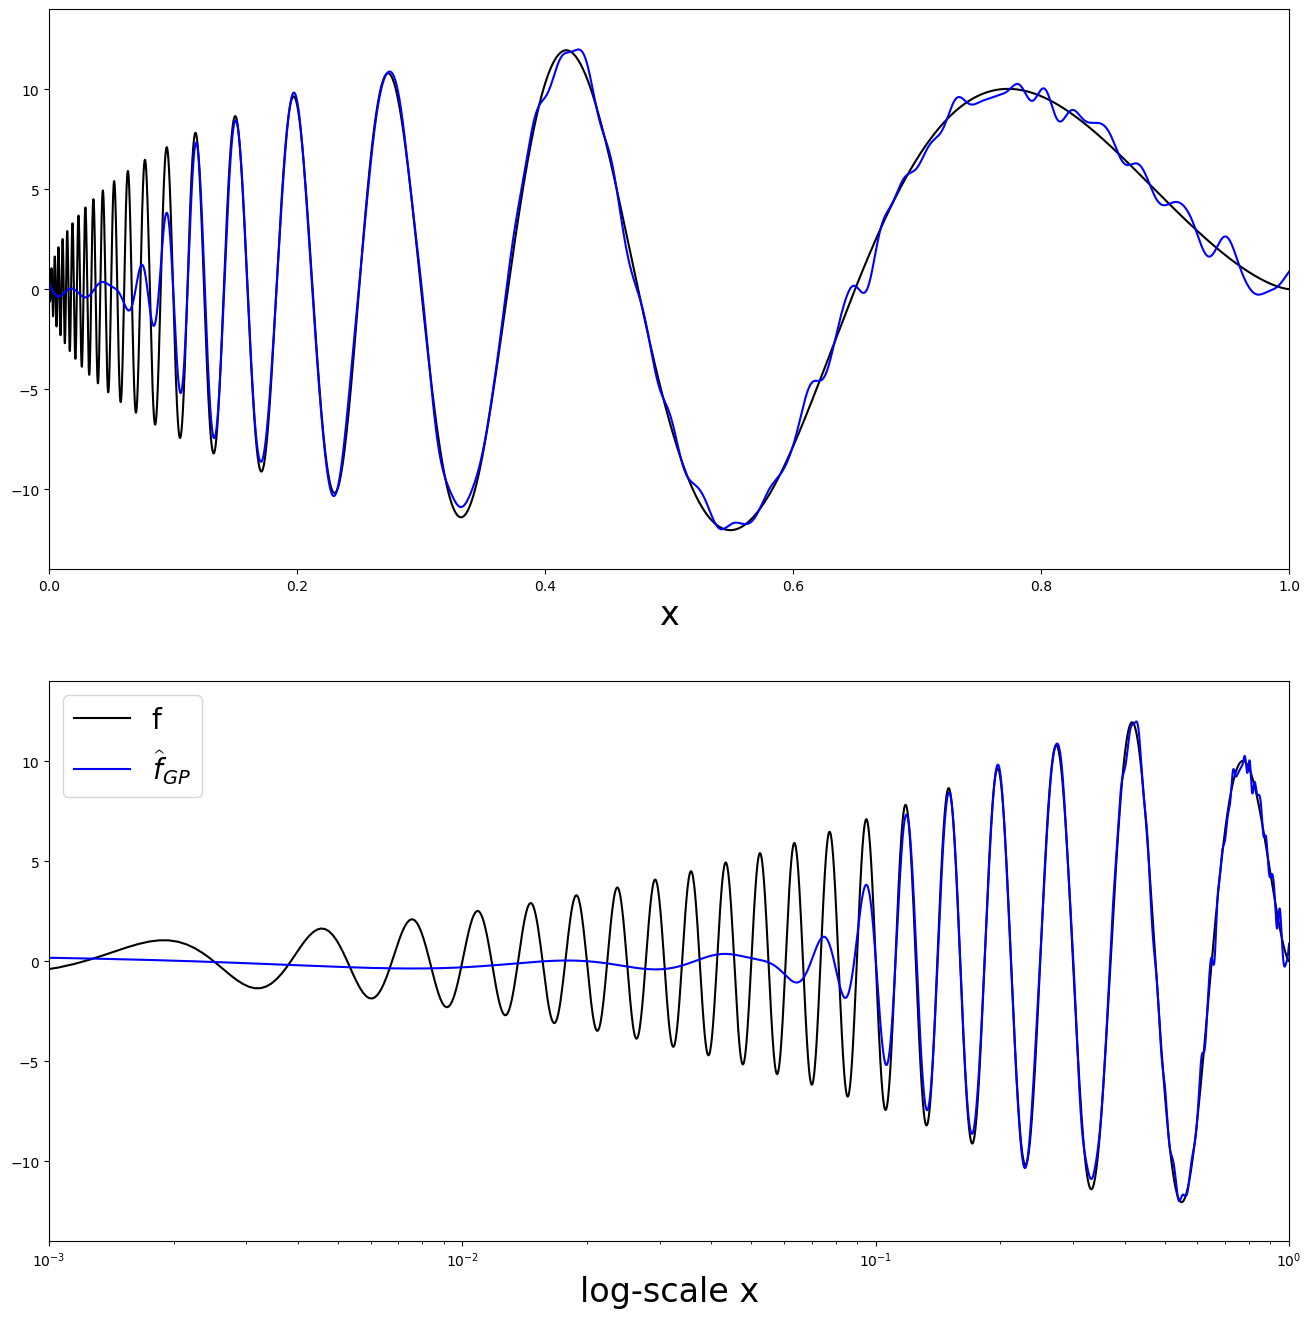

median global RMSE
[9.7727449]
median global MAE
[7.90543314]
median global max AE
[24.03300888]
initialize new experts
expert 0
initialize exact GP at bandwidth 1E-03 and lambda 1E+01
No pre-train needed for exact GP
expert 1
initialize exact GP at bandwidth 2.15E-03 and lambda 1E+01
No pre-train needed for exact GP
expert 2
initialize exact GP at bandwidth 4.64E-03 and lambda 1E+01
No pre-train needed for exact GP
expert 3
initialize exact GP at bandwidth 1E-02 and lambda 1E+01
No pre-train needed for exact GP
expert 4
initialize exact GP at bandwidth 2.15E-02 and lambda 1E+01
No pre-train needed for exact GP
expert 5
initialize exact GP at bandwidth 4.64E-02 and lambda 1E+01
No pre-train needed for exact GP
expert 6
initialize exact GP at bandwidth 1E-01 and lambda 1E+01
No pre-train needed for exact GP
find gate inducing points
apply SVGD sigma 8E-03
Gate parameters: batchSize 512, inducing points 128, valFreq 16, subValFreq 2, patience 8, sigmaPen 5E-01, sparsity K 2
estimate prec

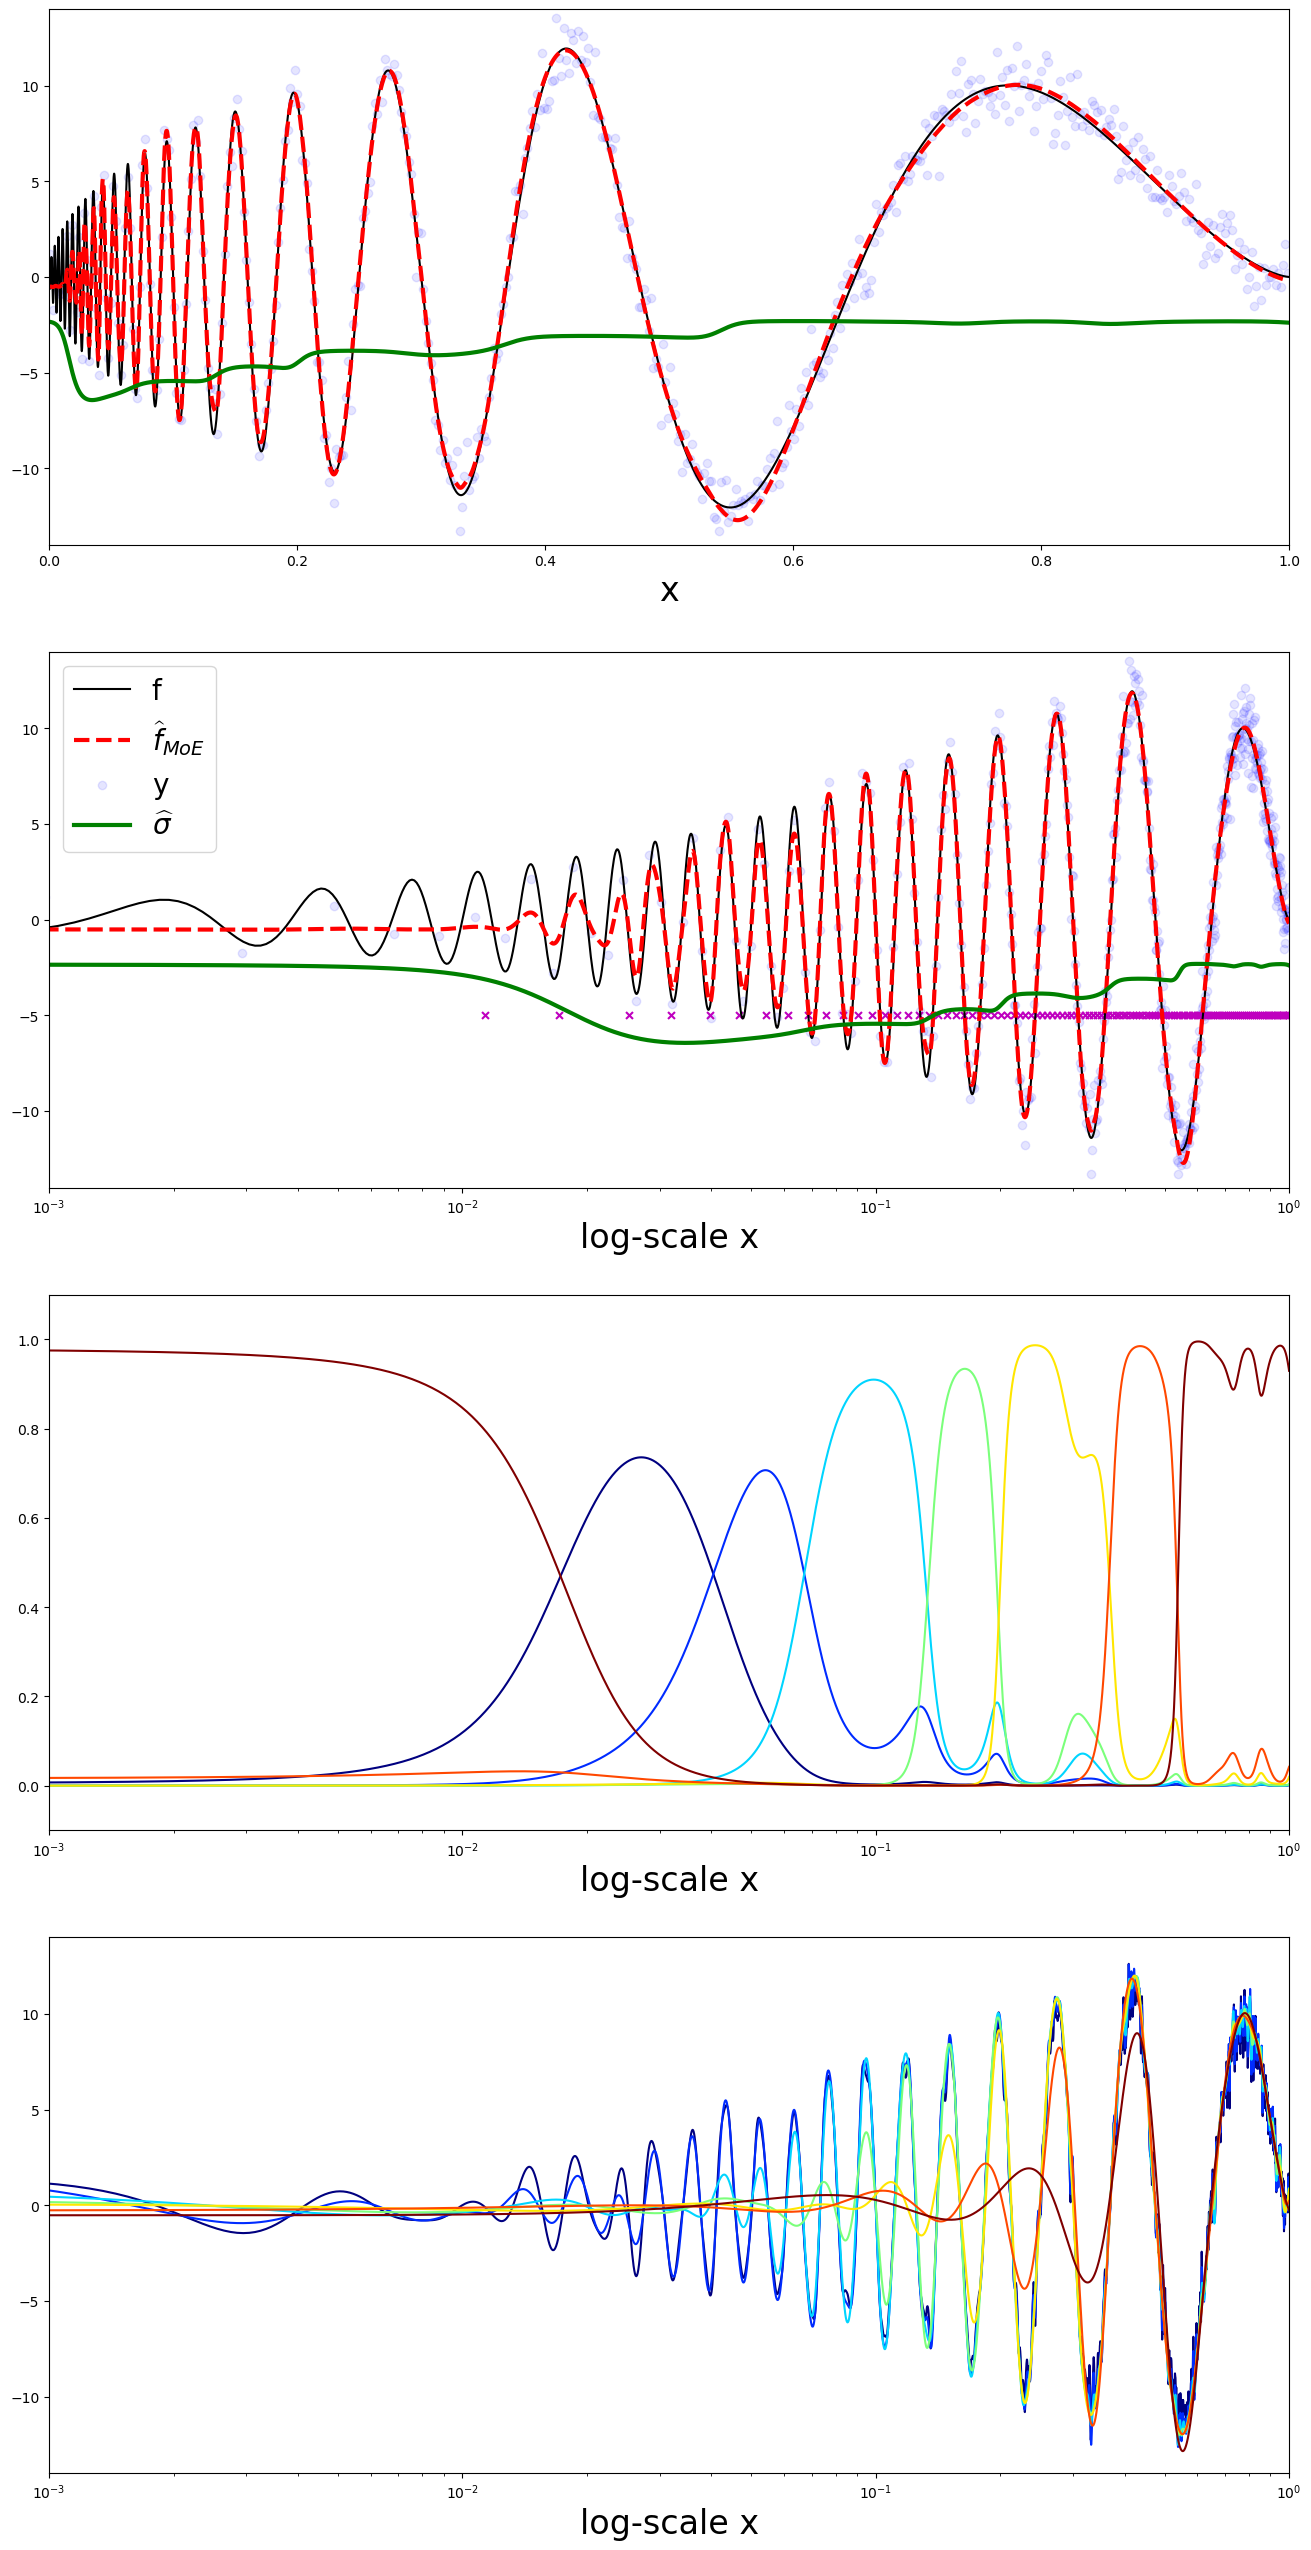

Iter 80, expert mean 1.22E+00, noise level 1E+00, lambda 1E+01, gate sigma 5E-02, lambda 1E+01 noisy gating 1.77E-02
Loss: 1.8E+00 = 1.58E+00 (objective) + 2.22E-01 (bandwidth penalty)
current validation MLL:  1.5026300112327173
current learning rate:  2E-02
Iter 96, expert mean 1.22E+00, noise level 1E+00, lambda 1E+01, gate sigma 5E-02, lambda 1E+01 noisy gating 1.25E-02
Loss: 1.78E+00 = 1.56E+00 (objective) + 2.16E-01 (bandwidth penalty)
current validation MLL:  1.4926124409639754
current learning rate:  2E-02
Iter 112, expert mean 1.22E+00, noise level 1E+00, lambda 1E+01, gate sigma 5E-02, lambda 1E+01 noisy gating 8.84E-03
Loss: 1.77E+00 = 1.56E+00 (objective) + 2.12E-01 (bandwidth penalty)
current validation MLL:  1.4890872488981124
current learning rate:  2E-02


KeyboardInterrupt: 

In [5]:
# outside loop: specify for each hyperparameter some initial value and a flag whether to tune the parameter or not
pInit = inputDensityUnif
pInitPlot = pInit(xPlot, alPars['inputSpaceBounds'])
if alPars['initialSamplingStrategy'] == 'random':
    randPInit = randInputUnif
elif alPars['initialSamplingStrategy'] == 'equi':
    randPInit = equidistantInput
else:
    raise NotImplementedError
labelOracle = noisyLabelFun
randUniform = randInputUnif
xRef = xPlot

resSABERopt_SABER = resultList(resultFile=resultFile)

for rep in range(expPars['repetitions']):
    
    clear_output()
    ####### set up global stuff for this repetition here (like validation and test data) ######
    if rep >= len(resSABERopt_SABER['allValXs']):
        seed = rep*(3*expPars['iters']+1)
        np.random.seed(seed)
        torch.manual_seed(seed+1)
        validationX = randInputUnif(expPars['validationSize'], inputSpaceBounds)
        validationY = noisyLabelFun(validationX)
        iwVal = None
        valInx = None

        xTest = xPlot
        fTest = labelFun(xTest)
        testInx = None
    
        resSABERopt_SABER.update(rep, valX = validationX, valY = validationY, testX = xTest, testY = fTest, valInx = None, testInx = None)
        resSABERopt_SABER.save()
    else:
        validationX = resSABERopt_SABER['allValXs'][rep]
        validationY = resSABERopt_SABER['allValYs'][rep]
        iwVal = None
        valInx = None

        xTest = resSABERopt_SABER['allTestXs'][rep]
        fTest = resSABERopt_SABER['allTestYs'][rep]
        testInx = None
    
    # set up the learner
    saberAL = activeLearner(expPars, alPars, testDensity = testDensity, randTestDistribution = randTestDistribution, randPInit = randPInit, pInit = pInit, randUniform = randUniform, labelOracle = labelOracle, xRef = xRef)
    
    if rep < len(resSABERopt_SABER['allXs']):
        # check if this repetition is fully calculated
        if len(resSABERopt_SABER['allXs'][rep]) >= expPars['trainingSizes'][-1] and len(resSABERopt_SABER['allSABERmodelsStateDict']) > rep and len(resSABERopt_SABER['allSABERmodelsStateDict'][rep]) >= expPars['iters']:
            continue
            
        # load so far calculated data
        saberAL.importPreviousData(resSABERopt_SABER['allXs'][rep], resSABERopt_SABER['allYs'][rep], densitiesInformation = resSABERopt_SABER['allDensitiesInformation'][rep])
        
    for j in range(expPars['iters']):
        n = expPars['trainingSizes'][j]
        if n < len(saberAL.X):
            # case: we already have data and model for this iteration
            continue
        
        if n == len(saberAL.X) and len(resSABERopt_SABER['allSABERmodelsStateDict']) > rep and len(resSABERopt_SABER['allSABERmodelsStateDict'][rep]) > j:
            # case: we already have data and model for this iteration
            continue
########## Summarize in Pserudo-Code the a whole step of the AL Framework ##############
###################### prior training updates ####################
        
        ##### sample a new batch according to current optimal density proposal ###########
        seed = rep*(3*expPars['iters']+1) + j + 1
        np.random.seed(seed)
        torch.manual_seed(seed+1)
        if n > len(saberAL.X):
            
            # set up current training distribution
            saberAL.updateTrainingDistribution()
            
            sampleSize = n - len(saberAL.X)
            
            saberAL.growTrainingData(sampleSize)
            
            resSABERopt_SABER.update(rep, X = saberAL.X, y = saberAL.y, densitiesInformation = saberAL.densitiesInformation, trainInx = saberAL.trainInx)
            resSABERopt_SABER.save()
            
            saberAL.updateTrainImportanceWeights()
            
        #estimate pTrainPlot:
        pTrainPlot = pInitPlot
        if saberAL.alPars['updateTrainingDensity'] and len(saberAL.densitiesInformation) > 1:
            for i in range(len(saberAL.densitiesInformation) - 1):
                w = saberAL.densitiesInformation[i]['densityWeight']
                pTrainPlot = pTrainPlot * w + resSABERopt_SABER['allPlotInformation'][rep][i]['proposalDensityPlot'] * (1-w)
            
        # apply hyperparameter heuristics to update some parameters based on train size
        alPars, ipSelectionPars, modelPars = hyperparameterHeuristics(n, expPars, alPars, ipSelectionPars, modelPars)
            
        # get the new IP selection strategies
        #inducing_point_method_expert, inducing_point_method_gate = defineIPsamplingMethod(saberAL, ipSelectionPars, alPars, modelPars, expertTrainingSubInx, gateTrainingSubInx)
        
        ipMetaSamplerPars = initIPsamplerPars(ipSelectionPars, alPars, modelPars)
        ipMetaSampler = inducingPointSampler(saberAL, pars = ipMetaSamplerPars)
        
        # if needed, estimate a global model to estimate shared expert parameters
        seed = rep*(3*expPars['iters']+1) + expPars['iters'] + j + 1
        np.random.seed(seed)
        torch.manual_seed(seed+1)
        
        if not alPars['noiseFree'] and not alPars['homoscedastic'] and localNoiseVariance is None:
            raise NotImplementedError
            # TODO: Need to provide a data-driven localNoiseVariance function estimate
            
        # define a global model and tune unspecified hyperparameters on validation set
        globalGPRpars = initGPRpars(modelPars, alPars)
        
        globalModel = globalGPR(saberAL.X, saberAL.y, iwTrain = saberAL.importanceWeights, lossFunction = None, pars = globalGPRpars, xVal = validationX, yVal = validationY, iwVal = iwVal, valLoss = expPars['valLoss'], localNoiseVariance = localNoiseVariance, labelModel = expPars['labelModel'], derivativeModel = expPars['derivativeModel'])
        
        # check if we already got a tuned global model
        if len(resSABERopt_SABER['allGlobalModelsStateDict']) > rep and len(resSABERopt_SABER['allGlobalModelsStateDict'][rep]) > j:
            globalStateDict = resSABERopt_SABER['allGlobalModelsStateDict'][rep][j]
        else:
            globalStateDict = None
        inducing_point_method_global = ipMetaSampler(IPstrategy = ipSelectionPars['IPstrategyExpert'])
        
        globalModel.init(inducing_points = None, inducing_point_method = inducing_point_method_global, modelStateDict = globalStateDict)
        if globalStateDict is None:
            globalModel.preTrainModel()
            globalModel.trainModel()

            resSABERopt_SABER.update(rep, globalModel_stateDict = globalModel.state_dict())
            resSABERopt_SABER.save()
        
        if len(resSABERopt_SABER['allGlobalTestErrors']) <= rep or len(resSABERopt_SABER['allGlobalTestErrors'][rep]) <= j:
            if len(xTest) > 0:
                with torch.no_grad():
                    testPredGlobal = globalModel(torch.from_numpy(xTest).type(globalModel.y.dtype), predictionsOnly = True).mean
                testPredGlobal = testPredGlobal.numpy()
                testMAEglobal = np.mean(np.abs(testPredGlobal - fTest))
                testRMSEglobal = np.mean((testPredGlobal - fTest)**2)**0.5
                testMaxAEglobal = np.max(np.abs(testPredGlobal - fTest))

                fig, ax = plt.subplots(2, 1)
                fig.set_figheight(16)
                fig.set_figwidth(16)
                ax[0].set_xlabel('x', fontsize=24)
                ax[0].set_xlim(0,1)
                ax[0].set_ylim(-14, 14)
                ax[0].plot(xPlot, yPlot, 'k-',label='f')
                ax[0].plot(xTest, testPredGlobal, color = "blue", label='$\widehat{f}_{GP}$')
                ############
                ax[1].set_xlabel('log-scale x', fontsize=24)
                ax[1].set_xlim(0.001, 1.)
                ax[1].set_ylim(-14, 14)
                ax[1].semilogx(xPlot, yPlot, 'k-',label='f')
                ax[1].plot(xTest, testPredGlobal, color = "blue", label='$\widehat{f}_{GP}$')
                ############

                ##########
                ax[1].legend(loc='upper left', fontsize = 20)
                plt.draw()
                plt.pause(2)
                plt.close(fig)
            else:
                testMAEglobal = np.double(np.nan)
                testRMSEglobal = np.double(np.nan)
                testMaxAEglobal = np.double(np.nan)
                
            globalTestErrors = {'RMSE': testRMSEglobal, 'MAE': testMAEglobal, 'maxAE': testMaxAEglobal}
                
            resSABERopt_SABER.update(rep, globalTestErrors = globalTestErrors)
            resSABERopt_SABER.save()
        
        print('median global RMSE')
        print(np.nanmedian(numpy_fillna([[err['RMSE'] for err in errors] for errors in resSABERopt_SABER['allGlobalTestErrors']]),0))
        print('median global MAE')
        print(np.nanmedian(numpy_fillna([[err['MAE'] for err in errors] for errors in resSABERopt_SABER['allGlobalTestErrors']]),0))
        print('median global max AE')
        print(np.nanmedian(numpy_fillna([[err['maxAE'] for err in errors] for errors in resSABERopt_SABER['allGlobalTestErrors']]),0))
        
        #TODO: transfer some globally estimated parameters to init SABER model       
        SABERpars = initSABERpars(expPars, modelPars, alPars)
        
        # set up SABER model
        seed = rep*(3*expPars['iters']+1) + 2*expPars['iters'] + j + 1
        np.random.seed(seed)
        torch.manual_seed(seed+1)
        saberModel = SABER(saberAL.X, saberAL.y, iwTrain = saberAL.importanceWeights, lossFunction = None, pars = SABERpars, xVal = validationX, yVal = validationY, iwVal = iwVal, valLoss = expPars['valLoss'], localNoiseVariance = localNoiseVariance)
        
        saberModel.init(ipMetaSampler, ipSelectionPars, modelStateDict = None)
        saberModel.trainModel(printMethod = printDoppler, plotFrequencyFactor = modelPars['plotFrequencyFactor'])
        
        # estimate proposed superior training density (and some other intermediate results)
        saberAL.updateLocalProperties(saberModel.localBandwidthFunction, saberModel.localNoiseVarianceEstimate)
        
        # estimate local properties over xPlot for later visualization purpose
        plotInf = {}
        plotInf['trainingDensityPlot'] = pTrainPlot
        with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
            plotInf['sigmaPlot'] = saberAL.localBandwidthEstimate(xPlot)
            plotInf['complexityPlot'] = saberAL.localFunctionComplexityEstimate(xPlot, pCurrentOfX = pTrainPlot, bandwidthOfX = plotInf['sigmaPlot'])
            plotInf['proposalDensityPlot'] = saberAL.proposalDensityEstimate(xPlot, pCurrentOfX = pTrainPlot, q = testDensityPlot, lfc = plotInf['complexityPlot'])
        
        resSABERopt_SABER.update(rep, densitiesInformation = saberAL.densitiesInformation, SABERmodel_stateDict = saberModel.state_dict(), plotInformation = plotInf)
        resSABERopt_SABER.save()
        
        # measure performance
        if len(xTest) > 0:
            with torch.no_grad():
                testPred, = saberModel(torch.from_numpy(xTest).type(saberModel.model.gate.variational_strategy.base_variational_strategy.inducing_points.dtype), predictionsOnly = True)
            testPred = testPred.numpy()

            testMAE = np.mean(np.abs(testPred - fTest))
            testRMSE = np.mean((testPred - fTest)**2)**0.5
            testMaxAE = np.max(np.abs(testPred - fTest))
        else:
            testMAE = np.double(np.nan)
            testRMSE = np.double(np.nan)
            testMaxAE = np.double(np.nan)
            
        testErrors = {'RMSE': testRMSE, 'MAE': testMAE, 'maxAE': testMaxAE}
        
        resSABERopt_SABER.update(rep, testErrors = testErrors)
        resSABERopt_SABER.save()
        
        print('median RMSE')
        print(np.nanmedian(numpy_fillna([[err['RMSE'] for err in errors] for errors in resSABERopt_SABER['allTestErrors']]),0))
        print('median MAE')
        print(np.nanmedian(numpy_fillna([[err['MAE'] for err in errors] for errors in resSABERopt_SABER['allTestErrors']]),0))
        print('median max AE')
        print(np.nanmedian(numpy_fillna([[err['maxAE'] for err in errors] for errors in resSABERopt_SABER['allTestErrors']]),0))
        